In [3]:
#导入必要的库
%matplotlib inline

#==================自带库===================
from os import listdir,makedirs
from os.path import join,exists,expanduser

#====================数据处理库==============
import numpy as np
import pandas as pd

#===================绘图库==================
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

#===================时间,进度处理============
from tqdm import tqdm
import datetime as dt

#================= sklearn=================
from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression

#====================Keras=================
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input,decode_predictions


print("import done")

Using TensorFlow backend.


import done


In [4]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 1987
data_dir = '/home/mxq/Codes/Keras/breeddogs/data'
labels = pd.read_csv('data/labels.csv')
#print(len(listdir(data_dir)),len(labels))
# 10222 10222
selected_breed_list = list(labels.groupby('breed').count().sort_values(
    by='id',ascending=False).head(NUM_CLASSES).index)
# ['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 
#  'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian',
#  'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg', 
#  'cairn', 'beagle', 'japanese_spaniel']
labels = labels[labels['breed'].isin(selected_breed_list)]
# [1777 rows x 2 columns]

labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id','breed','target').reset_index().fillna(0)

np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8

y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]
#print(ytr,yv)

In [5]:
def read_img(img_id, train_or_test, size):
    """Read and resize image
       # Arguments
           img_id:string
           train_or_test:string 'train' or 'test'
           size:resize the original image
           
        # Returns
           Image as numpy array
    """
    img = image.load_img(join(data_dir,train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

# ResNet50 class predictions for example images

In [6]:
model = ResNet50(weights='imagenet')
print('load done !')

load done !


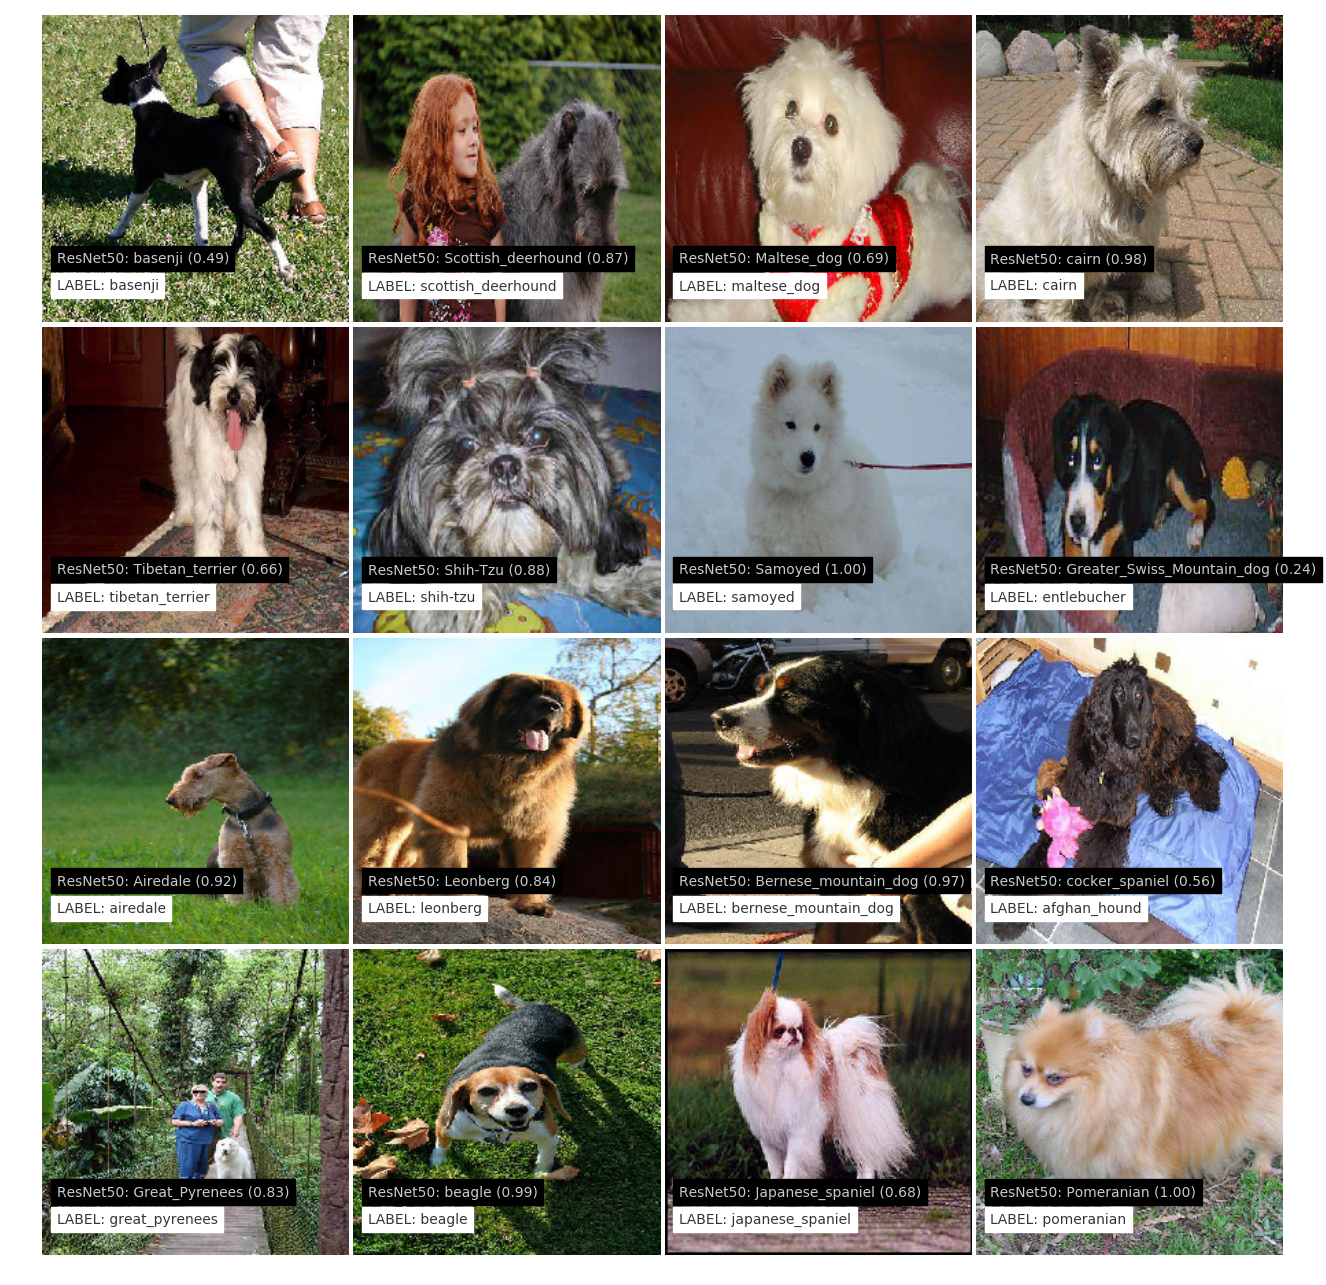

In [7]:
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

# Extract VGG16 bottleneck features

In [9]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:09, 179.33it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32)
#valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
#print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
#print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))


In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
